# Seas the Data

In [ ]:
%matplotlib widget
# Included widget so I could manually zoom in on the data
import sys
from pathlib import Path
from typing import Optional
import logging

import matplotlib.pyplot as plt
import pandas as pd

from Model import RedemptionModel
from Analysis import AnalysisEngine, set_logging
from Context import Context

In [2]:
def run(
    path_in: Path,
    split_date: Optional[pd.Timestamp]=None,
    split_fraction: Optional[float]=None,
    split_test_timedelta: Optional[pd.Timedelta]=None,
    plot: bool=True,
    debug: bool=False,
    verbose: bool=True
) -> AnalysisEngine:
    ctx = Context(
        path_in=path_in,
        split_date=split_date,
        split_fraction=split_fraction,
        split_test_timedelta=split_test_timedelta,
        plot=plot,
        debug=debug,
        verbose=verbose
    )
    set_logging(ctx)
    logging.info(
        f"Starting analysis with:\n"
        f"\tContext : {ctx}"
    )
    logging.info("Constructing analysis engine.")
    ae = AnalysisEngine(ctx)
    ae.read_csv(path_in)

    ae.prepare_for_projection()
    if ae.ctx.plot:
        ae.profile_sub_day.reset_index().plot(
            x="Time_of_day",
            y=["Redemption Count_mean", "Sales Count_mean"],
            figsize=(14,5),
            title="Sub-day profile"
        )
        ae.profile_weekly.reset_index().plot(
            x="Day_of_week",
            y=["Redemption Count", "Sales Count"],
            kind="line",
            marker="o",
            figsize=(14, 5),
            title="Weekly profile"
        )
        ae.profile_annual.plot(
            figsize=(12, 5),
            title="Annual profile"
        )
        # Rolling trend only used during dev for insights
        # ae.trend_rolling.plot(
        #     figsize=(14, 5),
        #     title="30-day rolling average"
        # )
        # Plot Take2 and Take3 - yearly summations and rolling average
        ax = ae.df_yearly.plot(
            kind="line",
            marker="o",
            figsize=(12, 5),
            title="Overall trend"
        )
        ae.df_yearly_rolling.plot(
            kind="line",
            marker="x",
            linestyle="--",
            ax=ax,
            label=["Redemption Trend", "Sales Trend"]
        )

        plt.xlabel("Year")
        plt.ylabel("Total Count")
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    return ae

INFO: Starting analysis with:
	Context : Context(path_in=WindowsPath('data/Toronto Island Ferry Ticket Counts.csv'), split_date=None, split_fraction=None, split_test_timedelta=Timedelta('365 days 00:00:00'), plot=True, verbose=True, debug=False)
INFO: Constructing analysis engine.
INFO: Reading data from data\Toronto Island Ferry Ticket Counts.csv
INFO: Training set : 220542
Testing set  : 26120
INFO: Component 1 - sub-day profile
INFO: Component 2 - weekly profile
INFO: Component 3 - annual profile
INFO: Component 4 - overall trend


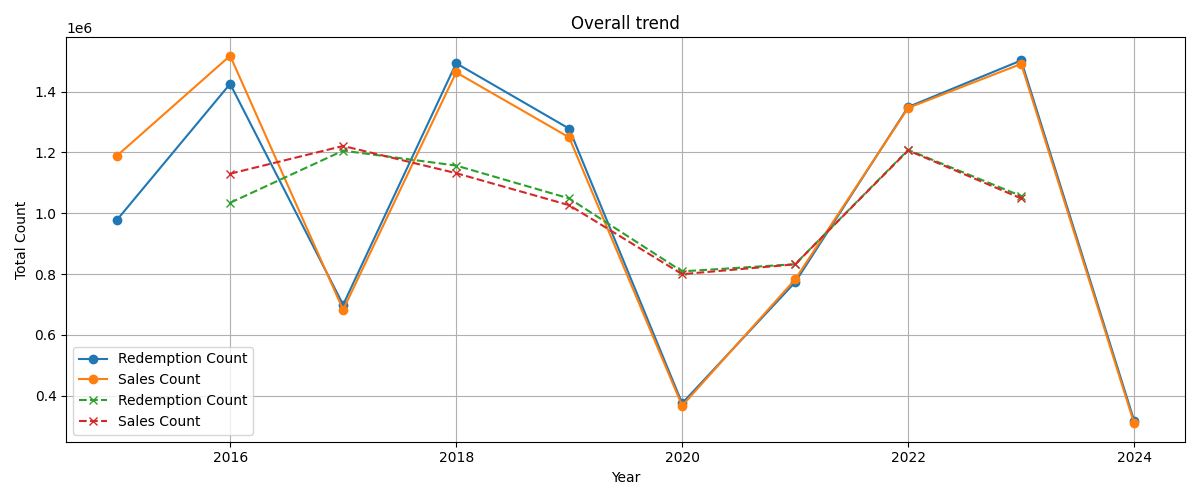

INFO: Evaluating uncertainty using test set
INFO: Extrapolating to year 2024
INFO: Extrapolating to year 2025
INFO: Uncertainty Evaluation Complete:
	MAE  :	Redemption Count    27.011137
Sales Count         25.980601
dtype: float64
	RMSE :	Redemption Count    81.992521
Sales Count         78.614390
dtype: float64
	STD  :	Redemption Count    80.682171
Sales Count         77.045729
dtype: float64


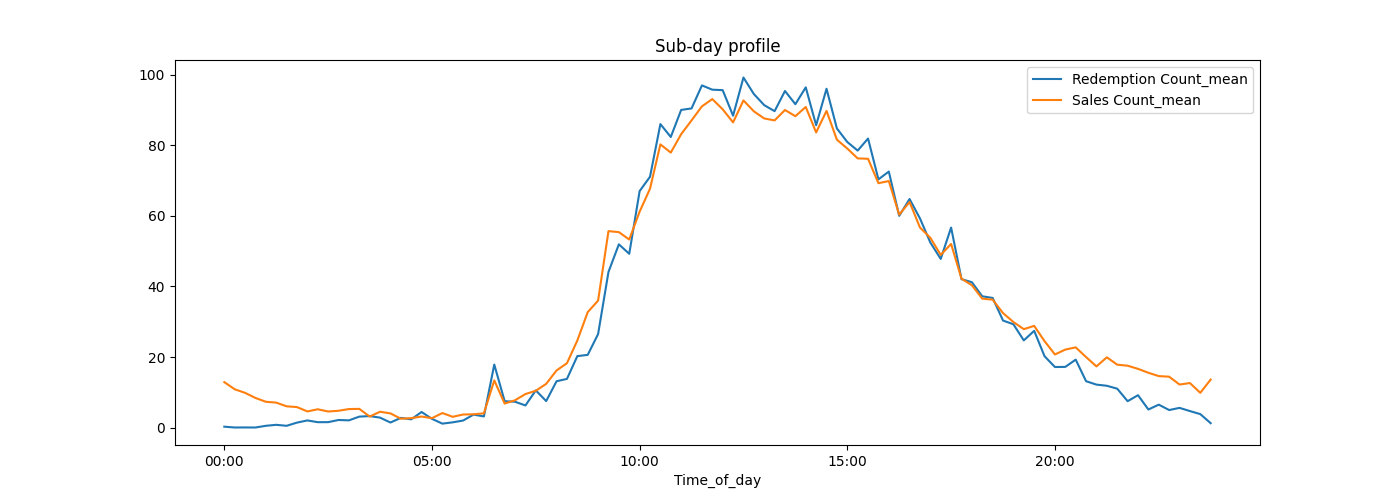

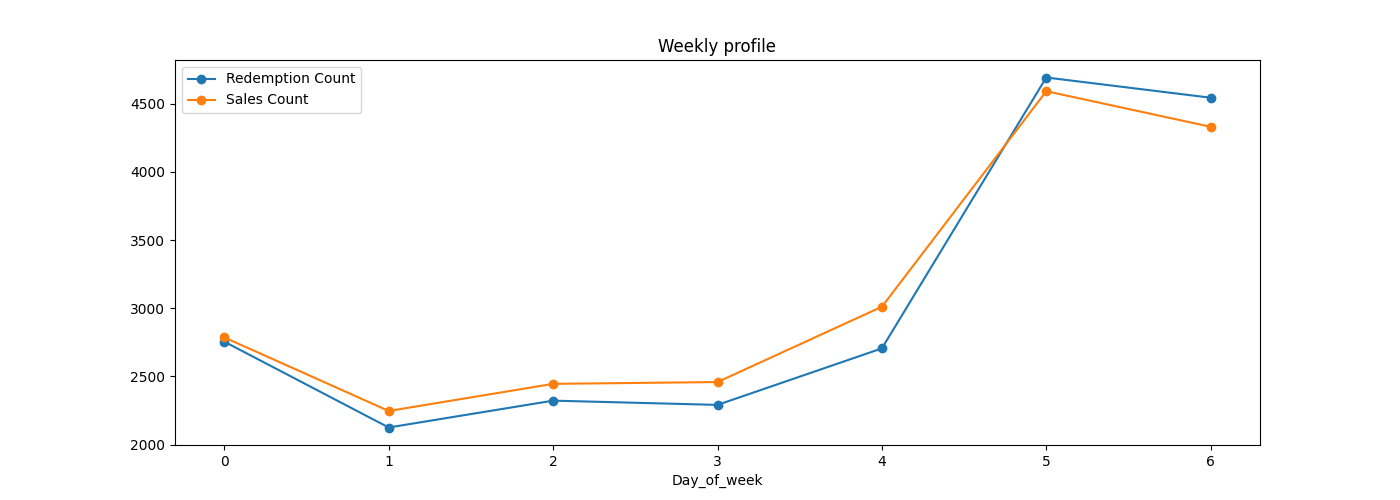

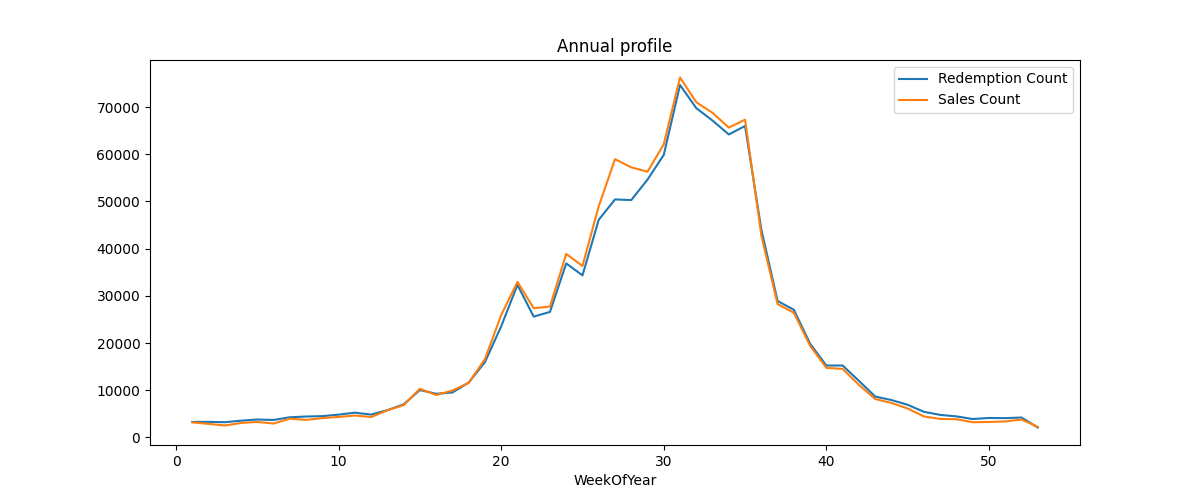

In [3]:
# Build analysis engine, cutting the last year off for testing / uncertainty
ae = run(
    Path("./data/Toronto Island Ferry Ticket Counts.csv"),
    split_date=None,
    split_fraction=None,
    split_test_timedelta=pd.Timedelta(365, "d"),
    verbose=True
)
# Establish uncertainty
ae.evaluate_uncertainty()

In [4]:
def compare_projections_for_year(ae, year: int, utype: str = "STD"):
    """
    Compare actual and projected sales/redemptions for a given year,
    including ±1sigma uncertainty bands and a zoomed subplot.
    """
    utype = utype.upper()
    assert utype in ["MAE", "RMSE", "STD"], f"Invalid uncertainty type: {utype}"

    # Ensure uncertainty is calculated
    if not hasattr(ae, "uncertainty_metrics"):
        ae.evaluate_uncertainty()

    # Get uncertainty deltas per column
    u_redemption = ae.uncertainty_metrics.loc["Redemption Count", utype]
    u_sales = ae.uncertainty_metrics.loc["Sales Count", utype]

    # Filter actual data
    df_actual = ae.df_train[ae.df_train.index.year == year]
    df_actual = df_actual.resample("15min").sum()

    # Build predicted DataFrame
    timestamps = df_actual.index
    projections = [ae.project_sub_day_interval(ts) for ts in timestamps]

    df_projection = pd.DataFrame(
        projections,
        index=timestamps,
        columns=["Redemption Count", "Sales Count"]
    )

    # Create full and zoomed views
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=False)

    # --- Full-year plot ---
    ax1.plot(
        df_actual.index,
        df_actual["Sales Count"],
        label="Actual Sales",
        alpha=0.6
    )
    ax1.plot(
        df_projection.index,
        df_projection["Sales Count"],
        label="Predicted Sales",
        linestyle="--"
    )
    ax1.fill_between(
        df_projection.index,
        df_projection["Sales Count"] - u_sales,
        df_projection["Sales Count"] + u_sales,
        color='orange',
        alpha=0.3,
        label="Sales ±1sigma"
    )

    ax1.plot(
        df_actual.index,
        df_actual["Redemption Count"],
        label="Actual Redemptions",
        alpha=0.6
    )
    ax1.plot(
        df_projection.index,
        df_projection["Redemption Count"],
        label="Predicted Redemptions",
        linestyle="--"
    )
    ax1.fill_between(
        df_projection.index,
        df_projection["Redemption Count"] - u_redemption,
        df_projection["Redemption Count"] + u_redemption,
        color='green',
        alpha=0.3,
        label="Redemptions ±1sigmaz"
    )

    ax1.set_title(f"Actual vs Predicted Counts with Uncertainty for {year}")
    ax1.set_ylabel("Counts")
    ax1.grid(True)
    ax1.legend()

    # --- Zoomed-in view ---
    zoom_start = pd.Timestamp("2024-05-10")
    zoom_end = pd.Timestamp("2024-05-19")

    # Slice data
    df_actual_zoom = df_actual.loc[zoom_start:zoom_end]
    df_projection_zoom = df_projection.loc[zoom_start:zoom_end]

    ax2.plot(
        df_actual_zoom.index,
        df_actual_zoom["Sales Count"],
        label="Actual Sales",
        alpha=0.6
    )
    ax2.plot(
        df_projection_zoom.index,
        df_projection_zoom["Sales Count"],
        label="Predicted Sales",
        linestyle="--"
    )
    ax2.fill_between(
        df_projection_zoom.index,
        df_projection_zoom["Sales Count"] - u_sales,
        df_projection_zoom["Sales Count"] + u_sales,
        color='orange',
        alpha=0.3,
        label="Sales ±1sigma"
    )

    ax2.plot(
        df_actual_zoom.index,
        df_actual_zoom["Redemption Count"],
        label="Actual Redemptions",
        alpha=0.6
    )
    ax2.plot(
        df_projection_zoom.index,
        df_projection_zoom["Redemption Count"],
        label="Predicted Redemptions",
        linestyle="--"
    )
    ax2.fill_between(
        df_projection_zoom.index,
        df_projection_zoom["Redemption Count"] - u_redemption,
        df_projection_zoom["Redemption Count"] + u_redemption,
        color='green',
        alpha=0.3,
        label="Redemptions ±1sigma"
    )

    ax2.set_title("Zoomed View: 2024-05-10 to 2024-05-19")
    ax2.set_ylabel("Counts")
    ax2.set_xlabel("Time")
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()
    plt.show()


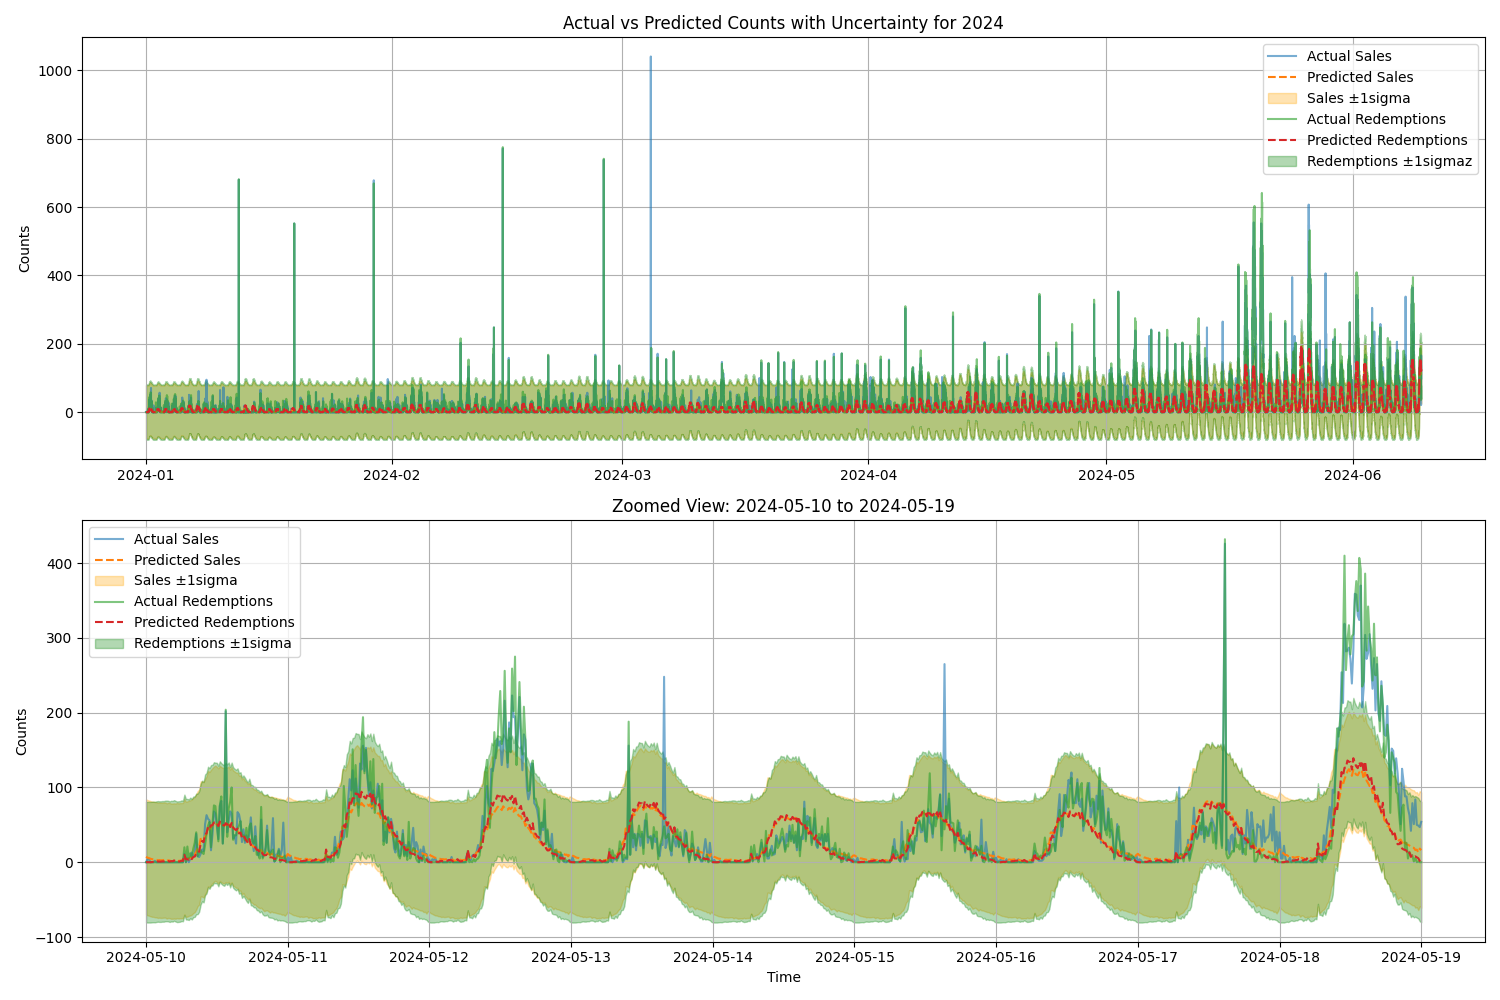

In [ ]:
# This looks at an area where the model forecasts (from training data) into
# other existing data (test data)
compare_projections_for_year(ae, 2024, "STD")

In [6]:
# Project the next year of data
projection = ae.create_full_year_projection(2025)
ae.add_uncertainty_to_projection(projection, "std")

INFO: Generating full-year projection for 2025


INFO: Projection complete: 35040 intervals generated.


In [7]:
def plot_projection_with_uncertainty(projection: pd.DataFrame, title: str):
    import matplotlib.pyplot as plt

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=False)

    # --- Full-range plot ---
    for col in ['Redemption Count', 'Sales Count']:
        ax1.plot(projection.index, projection[col], label=f'{col} (projection)')
        ax1.fill_between(
            projection.index,
            projection[f'{col} -1sigma'],
            projection[f'{col} +1sigma'],
            alpha=0.3,
            label=f'{col} ±1sigma'
        )

    ax1.set_title(title)
    ax1.set_ylabel('Count')
    ax1.legend()
    ax1.grid(True)

    # --- Zoomed-in plot ---
    zoom_start = pd.Timestamp('2025-07-01')
    zoom_end = pd.Timestamp('2025-07-11')
    zoom_df = (
        projection[
            (projection.index >= zoom_start) & (projection.index <= zoom_end)
        ]
    )

    for col in ['Redemption Count', 'Sales Count']:
        ax2.plot(zoom_df.index, zoom_df[col], label=f'{col} (projection)')
        ax2.fill_between(
            zoom_df.index,
            zoom_df[f'{col} -1sigma'],
            zoom_df[f'{col} +1sigma'],
            alpha=0.3,
            label=f'{col} ±1sigma'
        )

    ax2.set_title(f"Zoomed In: {zoom_start.date()} to {zoom_end.date()}")
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Count')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


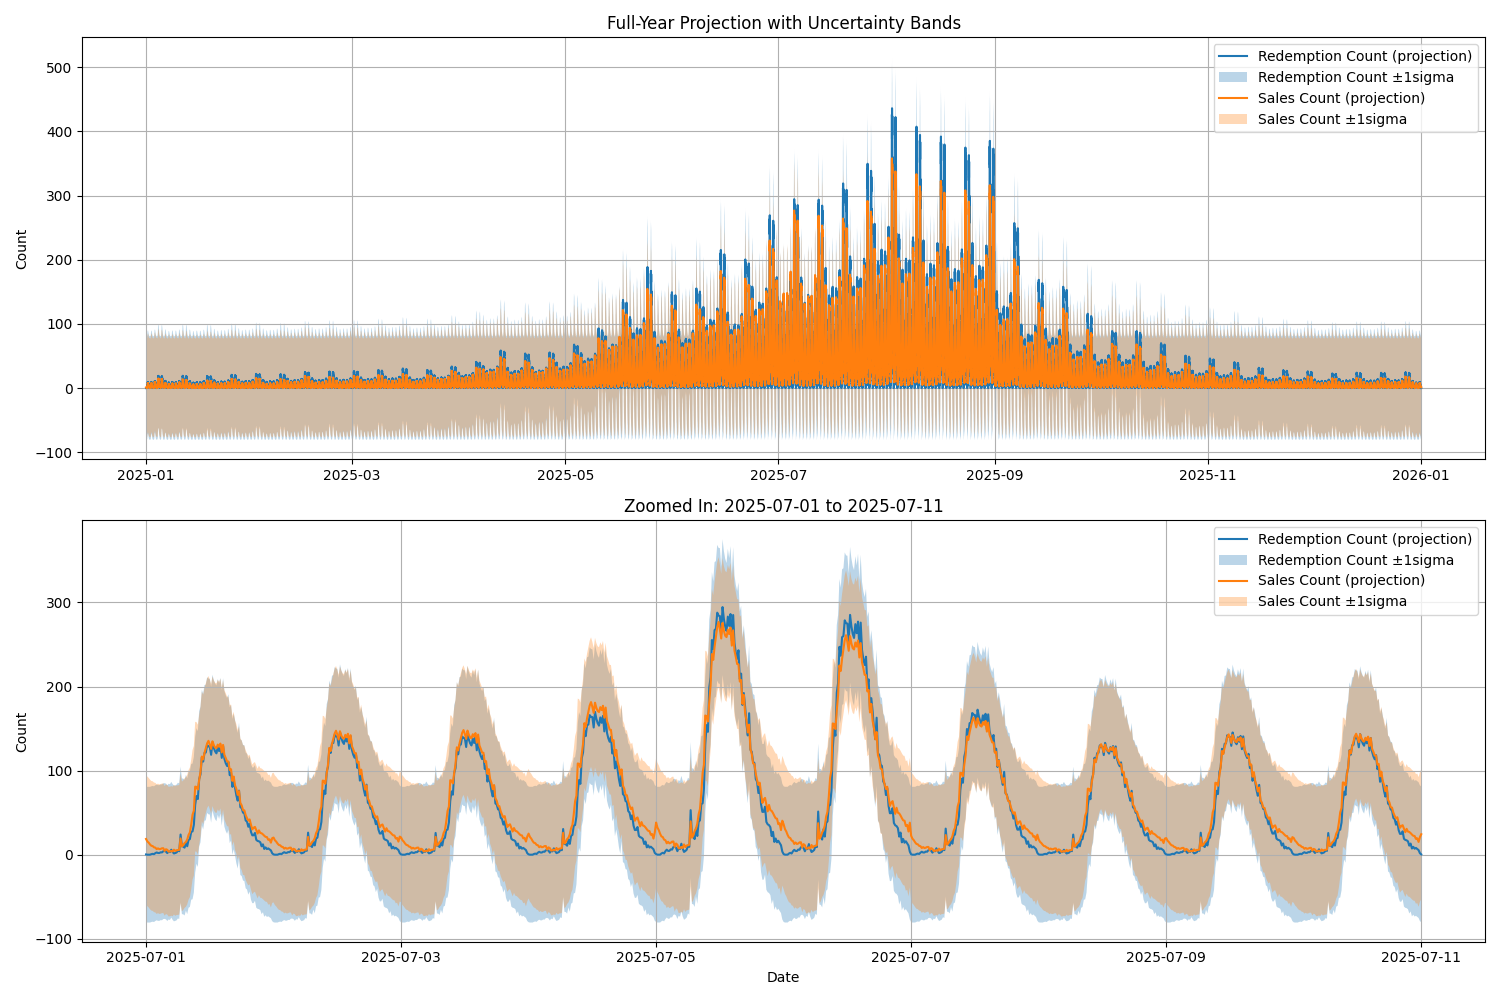

In [ ]:
# This one looks ahead into the future
plot_projection_with_uncertainty(
    projection, "Full-Year Projection with Uncertainty Bands"
)

In [9]:
def project_full_year(ae, year: int) -> pd.DataFrame:
    """Generate 15-minute resolution projection for an entire year."""
    # ae.prepare_for_projection()

    # Generate timestamps for the full year
    start = pd.Timestamp(f"{year}-01-01 00:00:00")
    end = pd.Timestamp(f"{year}-12-31 23:45:00")
    timestamps = pd.date_range(start=start, end=end, freq="15min")

    # Predict for each timestamp
    projections = [ae.project_sub_day_interval(ts) for ts in timestamps]

    # Create DataFrame
    df_projection = pd.DataFrame(
        projections,
        index=timestamps,
        columns=["Redemption Count", "Sales Count"]
    )

    fig, ax = plt.subplots(figsize=(14, 5))

    df_projection["Sales Count"].plot(ax=ax, label="Projected Sales", linestyle="-")
    df_projection["Redemption Count"].plot(ax=ax, label="Projected Redemptions", linestyle="--")

    ax.set_title("Projected Sales and Redemptions for 2026")
    ax.set_xlabel("Date")
    ax.set_ylabel("Count")
    ax.grid(True)
    ax.legend()
    plt.tight_layout()
    plt.show()
    return df_projection

INFO: Extrapolating to year 2026


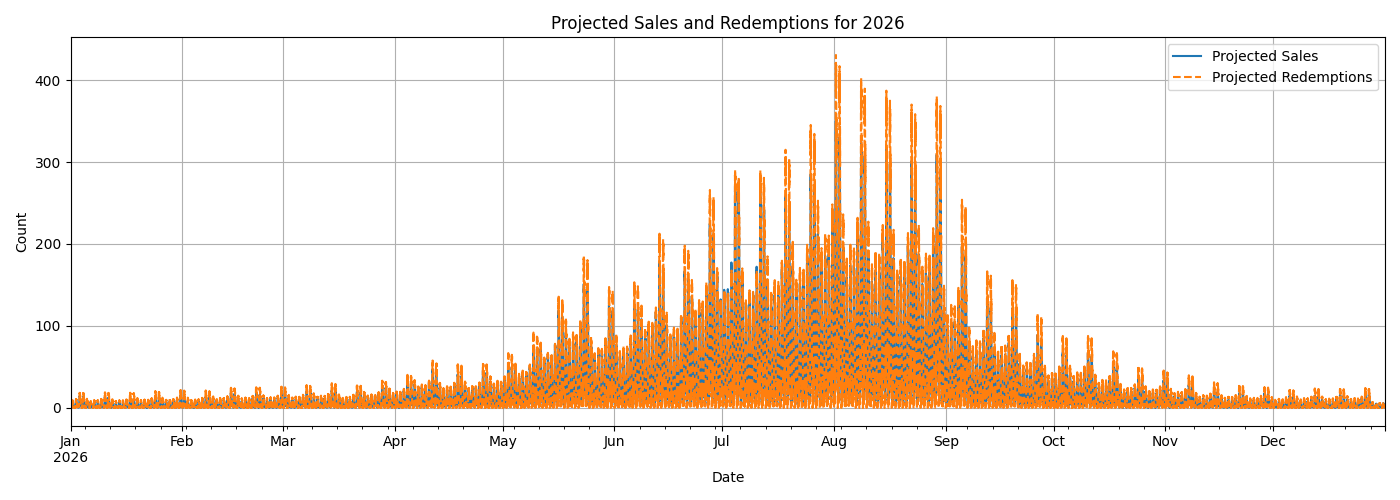

In [10]:
df_projection = project_full_year(ae, 2026)

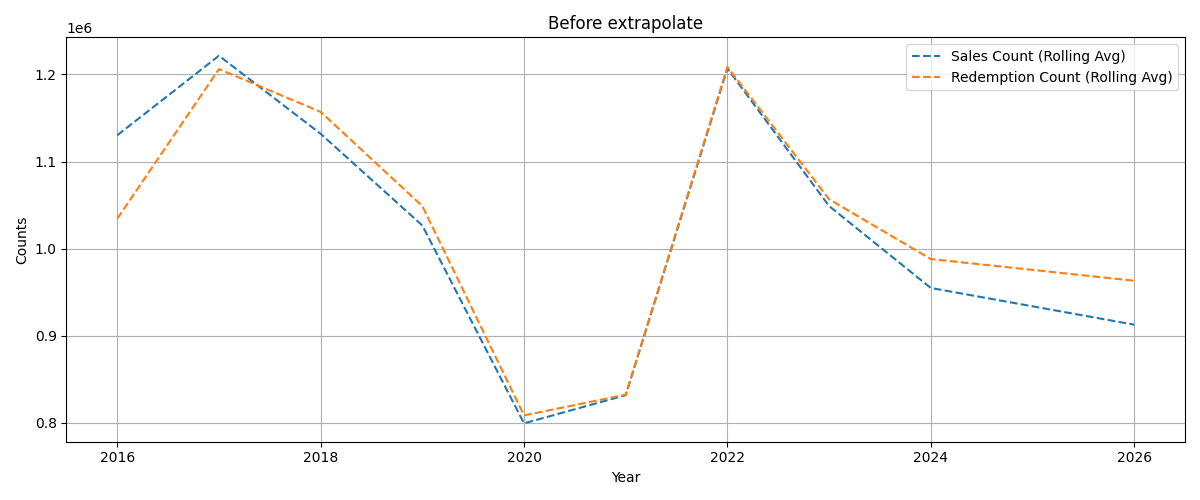

INFO: Extrapolating to year 2030


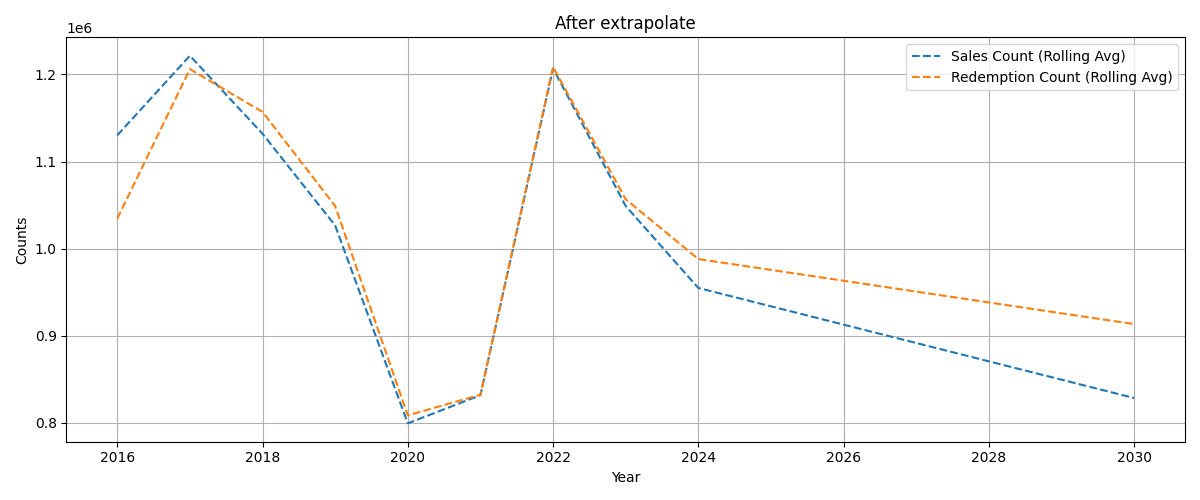

In [11]:
def plot_yearly_rolling(ae: AnalysisEngine, title: str):
    df = ae.df_yearly_rolling

    fig, ax = plt.subplots(figsize=(12, 5))
    df["Sales Count"].plot(ax=ax, label="Sales Count (Rolling Avg)", linestyle="--")
    df["Redemption Count"].plot(ax=ax, label="Redemption Count (Rolling Avg)", linestyle="--")

    ax.set_title(title)
    ax.set_xlabel("Year")
    ax.set_ylabel("Counts")
    ax.grid(True)
    ax.legend()
    plt.tight_layout()
    plt.show()
plot_yearly_rolling(ae, "Before extrapolate")
ae.extrapolate_year(2030)
plot_yearly_rolling(ae, "After extrapolate")

In [12]:
# Current dataset loaded = 2025-06-09T15:45:00 .. 2015-05-01T13:30:00
# Using split Timestamp

ae.evaluate_uncertainty()

INFO: Evaluating uncertainty using test set
INFO: Uncertainty Evaluation Complete:
	MAE  :	Redemption Count    27.011137
Sales Count         25.980601
dtype: float64
	RMSE :	Redemption Count    81.992521
Sales Count         78.614390
dtype: float64
	STD  :	Redemption Count    80.682171
Sales Count         77.045729
dtype: float64
